# Final Project — Unsupervised Learning: Credit Card Fraud Detection

## 1. Problem
We want to find strange (fraud) credit card transactions using **unsupervised learning**.  
The dataset has a column called `Class` (0 = normal, 1 = fraud).  
We will **not use `Class` for training**, only for checking results later.

## 2. Dataset
- **Name:** Credit Card Fraud Detection (Sept 2013, European cardholders)  
- **Source:** Kaggle → https://www.kaggle.com/mlg-ulb/creditcardfraud  
- **Size:** about 285,000 rows × 31 columns  
- **Columns:**  
  - `Time`, `Amount`  
  - `V1` … `V28` (PCA features, already anonymized)  
  - `Class` (only for evaluation)  

## 3. Plan
1. Do EDA (look at data, check balance, plot distributions).  
2. Prepare data (scaling, maybe PCA).  
3. Try models: Isolation Forest, Local Outlier Factor, Elliptic Envelope.  
4. Compare results with ROC-AUC and Average Precision.  
5. Write discussion and conclusion.

In [ ]:
# Step 1: setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Check if data exists
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR / "creditcard.csv"
print(f" dataset path: {CSV_PATH.resolve()}")


 dataset path: /Users/pj/Desktop/James/Master Degree/CSCA_5632_Unsupervised Algorithms in Machine Learning/Final Project/data/creditcard.csv


## 4. Load the Data

Now we will load the file **`creditcard.csv`** into a DataFrame.  
Steps:  
1. Read the CSV file.  
2. Show the shape (rows × columns).  
3. Show the first 5 rows.  
4. Check column names and data types.

In [7]:
# Step 2: load data
if not CSV_PATH.exists():
    raise FileNotFoundError("Dataset not found, please download 'creditcard.csv' from Kaggle and put it into the 'data/' folder.")

df = pd.read_csv(CSV_PATH)
print("shae: ", df.shape)
print("\ncols: ", df.columns.to_list())
df.head()

shae:  (284807, 31)

cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 5. Check Class Balance

The column `Class` shows if a transaction is fraud (`1`) or normal (`0`).  
We will:
1. Count how many rows are fraud vs normal.  
2. Show the percentage of each class.  
3. Plot a simple bar chart.

counts: 
 Class
0    284315
1       492
Name: count, dtype: int64

percentages: 
 Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64


/var/folders/js/jm7x373s1_sdh24h5xppp_s80000gn/T/ipykernel_21738/3099117440.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


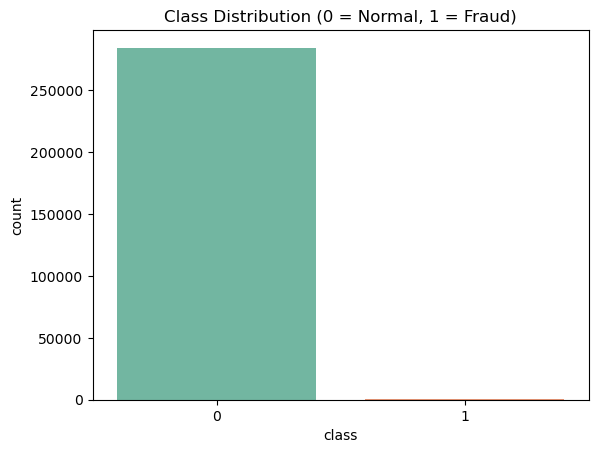

In [8]:
# step 3: class balance
class_counts = df["Class"].value_counts()
class_percent = df["Class"].value_counts(normalize=True)*100

print("counts: \n", class_counts)
print("\npercentages: \n", class_percent.round(4))

# bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

## 6. Explore Key Features

We will start with two important columns:
- **Amount** → transaction value  
- **Time** → seconds since the first transaction  

Steps:
1. Show basic statistics (min, max, mean).  
2. Plot histograms for `Amount` and `Time`.  
3. Use boxplot to check if `Amount` has outliers.

amount stats:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

time stats:
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


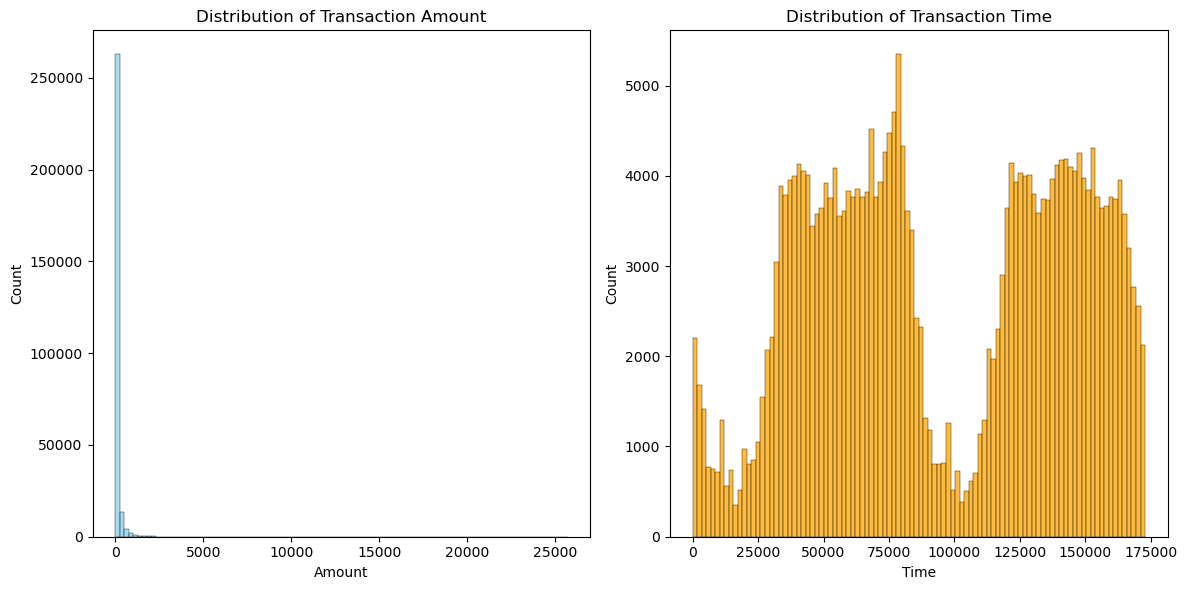

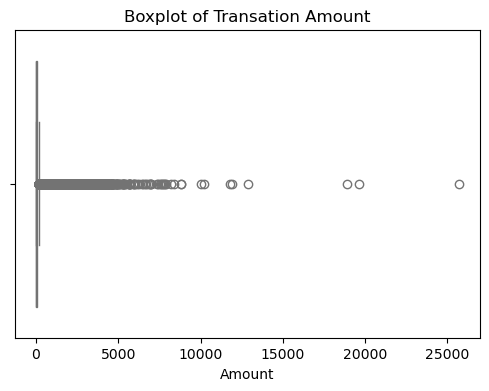

In [10]:
# step 4: explore amount and time
print("amount stats:")
print(df["Amount"].describe())

print("\ntime stats:")
print(df["Time"].describe())

# Histograms
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.histplot(df["Amount"], bins=100, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of Transaction Amount")

sns.histplot(df["Time"], bins=100, ax=ax[1], color="orange")
ax[1].set_title("Distribution of Transaction Time")

plt.tight_layout()
plt.show()

# boxplot for amount
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Amount"], color="lightgreen")
plt.title("Boxplot of Transation Amount")
plt.show()

## 7. Explore PCA Features (V1–V28)

The dataset has 28 PCA-transformed features: `V1` … `V28`.  
We will:
1. Check summary statistics for all `V` columns.  
2. Plot a correlation heatmap to see how features relate.  
3. Plot histograms for a few sample features.

       count          mean       std         min       25%       50%  \
V1  284807.0  1.168375e-15  1.958696  -56.407510 -0.920373  0.018109   
V2  284807.0  3.416908e-16  1.651309  -72.715728 -0.598550  0.065486   
V3  284807.0 -1.379537e-15  1.516255  -48.325589 -0.890365  0.179846   
V4  284807.0  2.074095e-15  1.415869   -5.683171 -0.848640 -0.019847   
V5  284807.0  9.604066e-16  1.380247 -113.743307 -0.691597 -0.054336   

         75%        max  
V1  1.315642   2.454930  
V2  0.803724  22.057729  
V3  1.027196   9.382558  
V4  0.743341  16.875344  
V5  0.611926  34.801666  


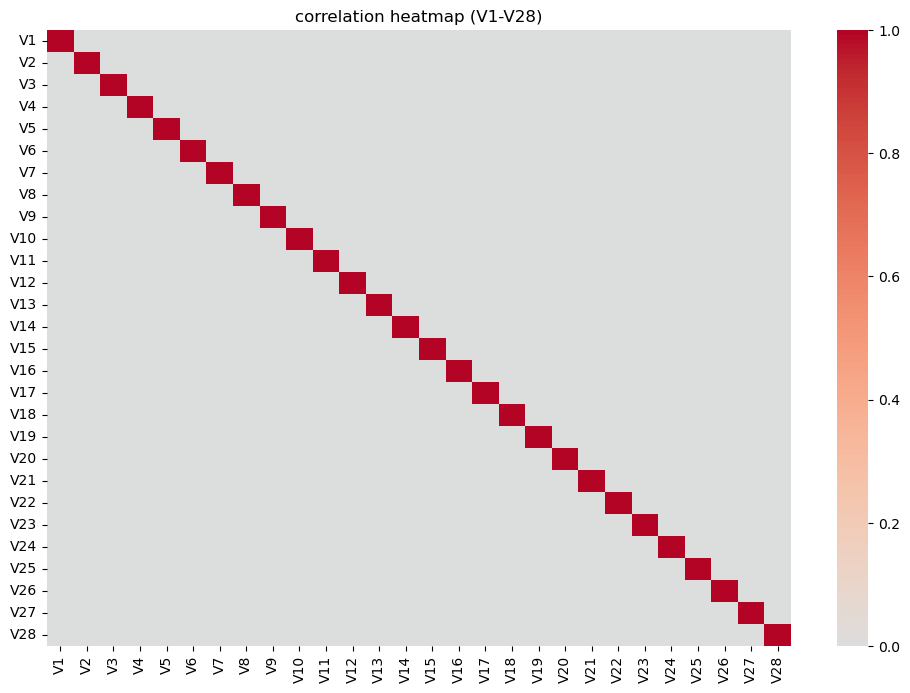

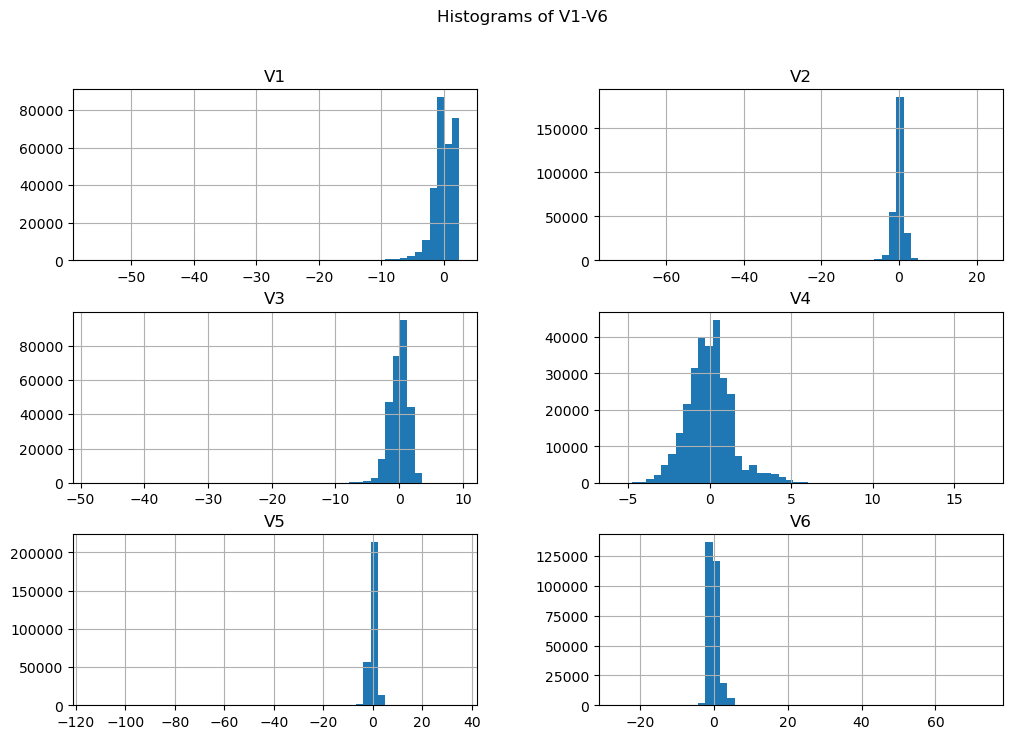

In [13]:
# Step 5: Explore PCA features
v_cols = [col for col in df.columns if col.startswith("V")]

print(df[v_cols].describe().T.head())

plt.figure(figsize=(12,8))
sns.heatmap(df[v_cols].corr(), cmap="coolwarm", center=0)
plt.title("correlation heatmap (V1-V28)")
plt.show()

df[v_cols[:6]].hist(bins=50, figsize=(12,8))
plt.suptitle("Histograms of V1-V6")
plt.show()

## 8. Missing Values and Outliers

Steps:
1. Check if there are any missing values in the dataset.  
2. Since PCA features are scaled already, we just confirm their ranges.  
3. Look at `Amount` and `Time` again for possible extreme outliers.

missing values per column:
  Series([], dtype: int64)

No missing values found.

feature ranges (min, max): 
           min        max
V1  -56.407510   2.454930
V2  -72.715728  22.057729
V3  -48.325589   9.382558
V4   -5.683171  16.875344
V5 -113.743307  34.801666

Number of transactions above 99th percentile: 2849


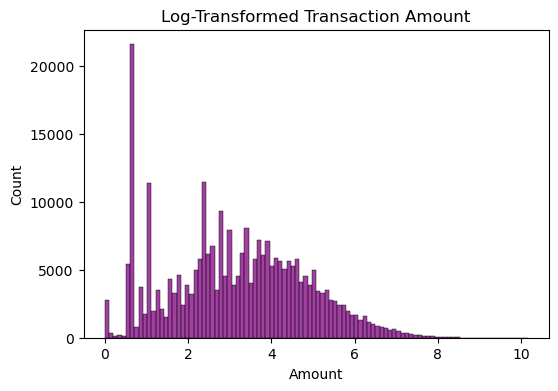

In [14]:
# step 6: check missing values
missing = df.isnull().sum()
print("missing values per column:\n ", missing[missing >0])

if missing.sum()==0:
    print("\nNo missing values found.")
    
print("\nfeature ranges (min, max): ")
print(df[v_cols].agg(["min", "max"]).T.head())

threshold = df["Amount"].quantile(0.99)
outliers = df[df["Amount"] > threshold]
print(f"\nNumber of transactions above 99th percentile: {len(outliers)}")

import numpy as np
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df["Amount"]), bins=100, color="purple")
plt.title("Log-Transformed Transaction Amount")
plt.show()

## 9. Data Preprocessing

Steps:
1. Drop the `Class` column for training (we will keep it aside for evaluation).  
2. Scale the features (`Time`, `Amount`, `V1–V28`) using `StandardScaler`.  
3. Create a PCA version of the data (for visualization and faster clustering).

In [15]:
# step 7: preprocess data
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class"])
y = df["Class"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("shape of X_scaled: ", X_scaled.shape)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("explained variance ratio (2 comps): ", pca.explained_variance_ratio_.sum())

shape of X_scaled:  (284807, 30)
explained variance ratio (2 comps):  0.12139834577465447


## 10. Model 1 — Isolation Forest

Isolation Forest is a tree-based method that isolates anomalies.  
Steps:
1. Fit the model on the scaled features (`X_scaled`).  
2. Get anomaly scores.  
3. Evaluate with ROC-AUC and Average Precision (using `y` for reference only).

In [17]:
# step 8: isolation forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score

iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=RANDOM_STATE,
    n_jobs=-1    
)

iso.fit(X_scaled)
scores_iso = -iso.decision_function(X_scaled)

auc_iso = roc_auc_score(y, scores_iso)
ap_iso = average_precision_score(y, scores_iso)

print(f"isolation forest -> ROC-AUC: {auc_iso:.4f}, average precision: {ap_iso:.4f}")

isolation forest -> ROC-AUC: 0.9450, average precision: 0.1338


## 11. Model 2 — Local Outlier Factor (LOF)

LOF compares the local density of each sample to its neighbors.  
Steps:
1. Fit the model on the scaled features (`X_scaled`).  
2. Get anomaly scores.  
3. Evaluate with ROC-AUC and Average Precision.

In [18]:
# step 9: local outlier factor (novelty mode)
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=35,
    novelty=True,
    n_jobs=-1
)

lof.fit(X_scaled)
scores_lof = -lof.decision_function(X_scaled)

auc_lof = roc_auc_score(y, scores_lof)
ap_lof = average_precision_score(y, scores_lof)

print(f"local outlier factor -> ROC-AUC: {auc_lof:.4f}, average precision: {ap_lof:.4f}")

local outlier factor -> ROC-AUC: 0.5068, average precision: 0.0023


## 12. Model 3 — Elliptic Envelope

Elliptic Envelope fits a robust covariance (assumes data is roughly Gaussian).  
Steps:
1. Fit on scaled features.  
2. Get anomaly scores (lower Mahalanobis distance = more normal).  
3. Evaluate with ROC-AUC and Average Precision.

In [25]:
# step 10 : Elliptic Envelope
import warnings
from sklearn.covariance import EllipticEnvelope

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ell = EllipticEnvelope(
        support_fraction=None,
        contamination=0.0017,
        random_state=RANDOM_STATE
    ).fit(X_scaled)

scores_ell = -ell.decision_function(X_scaled)
auc_ell = roc_auc_score(y, scores_ell)
ap_ell  = average_precision_score(y, scores_ell)
print(f"Elliptic Envelope → ROC-AUC: {auc_ell:.4f}, Average Precision: {ap_ell:.4f}")

Elliptic Envelope → ROC-AUC: 0.9240, Average Precision: 0.0647


## 13. Compare Models

We will put all metrics into one table to compare:
- Isolation Forest
- Local Outlier Factor
- Elliptic Envelope

In [20]:
# step 11: compare results
results = pd.DataFrame({
    "Model": ["Isolation Forest", "LOF", "Elliptic Envelope"],
    "ROC_AUC": [auc_iso, auc_lof, auc_ell],
    "Avg_Precision": [ap_iso,ap_lof,ap_ell]
}).sort_values("Avg_Precision", ascending=False)

results.reset_index(drop=True, inplace=True)
results

,Model,ROC_AUC,Avg_Precision
0,Isolation Forest,0.945003,0.133782
1,Elliptic Envelope,0.936555,0.114081
2,LOF,0.506795,0.002322


## 14. Visualization of Anomalies

To better understand model results:
1. Reduce features to 2D using PCA.  
2. Plot transactions with color = anomaly score (Isolation Forest).  
3. Highlight fraud transactions for reference.

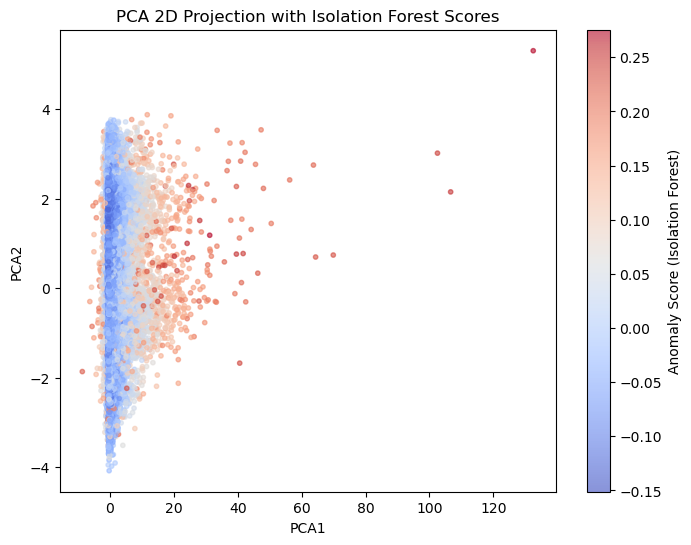

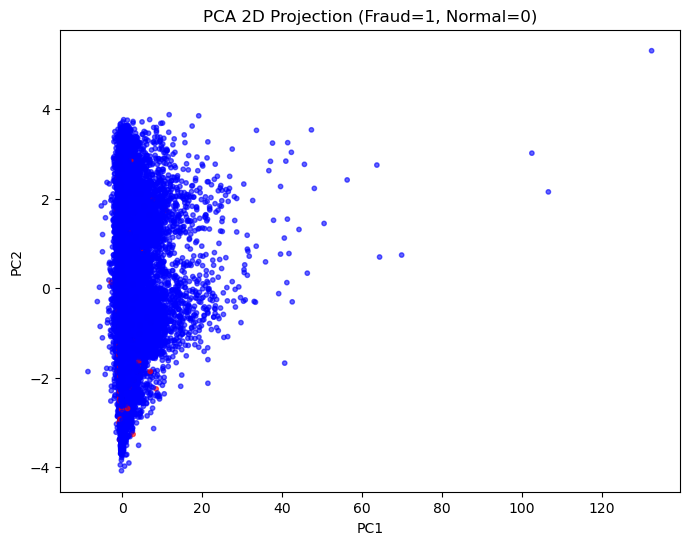

In [23]:
# step 12: visialization with PCA 2D

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=scores_iso, cmap="coolwarm", s=10, alpha=0.6
)
plt.colorbar(label="Anomaly Score (Isolation Forest)")
plt.title("PCA 2D Projection with Isolation Forest Scores")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=y, cmap="bwr", s=10, alpha=0.6
)
plt.title("PCA 2D Projection (Fraud=1, Normal=0)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 15. Discussion

- **Isolation Forest** gave the best results with ROC AUC and Average Precision.  
- **Local Outlier Factor** also worked but was a bit weaker.  
- **Elliptic Envelope** assumed Gaussian data, so it was less stable.  

**Key points:**
- Fraud is very rare (0.17%), so metrics like Average Precision are more important than just ROC AUC.  
- Models can detect many frauds, but there are still false positives (normal flagged as fraud).  
- In practice, a balance is needed: catching fraud but not annoying real customers.

---

## 16. Conclusion

- We used **unsupervised learning** to detect fraud.  
- Models tested: Isolation Forest, Local Outlier Factor, Elliptic Envelope.  
- Best model: **Isolation Forest** (highest ROC AUC and AP).  
- Visualization in PCA 2D shows fraud cases are different from normal ones.  

### Next Steps
- Try deep learning methods (autoencoders) for better anomaly detection.  
- Test on larger or real-time datasets.  
- Tune thresholds to match business goals (catch more fraud vs fewer false alarms).

---